# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 10            
model_seed = 0           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import SVHN_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# Optional: you can keep hidden_dims or increase due to higher input size
hidden_dims = [512, 256]  # Suggested for SVHN, but your choice

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics (unchanged)
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.3011 | Test Loss 2.3403 | accs Train 0.0667 Test 0.1422


Epoch 100/2000: Train Loss 0.0000 | Test Loss 12.0049 | accs Train 1.0000 Test 0.1687


Epoch 200/2000: Train Loss 0.0000 | Test Loss 12.1110 | accs Train 1.0000 Test 0.1676


Epoch 300/2000: Train Loss 0.0000 | Test Loss 12.1709 | accs Train 1.0000 Test 0.1672


Epoch 400/2000: Train Loss 0.0000 | Test Loss 12.2176 | accs Train 1.0000 Test 0.1668


Epoch 500/2000: Train Loss 0.0000 | Test Loss 12.2590 | accs Train 1.0000 Test 0.1663


Epoch 600/2000: Train Loss 0.0000 | Test Loss 12.2994 | accs Train 1.0000 Test 0.1659


Epoch 700/2000: Train Loss 0.0000 | Test Loss 12.3307 | accs Train 1.0000 Test 0.1657


Epoch 800/2000: Train Loss 0.0000 | Test Loss 12.3585 | accs Train 1.0000 Test 0.1660


Epoch 900/2000: Train Loss 0.0000 | Test Loss 12.3834 | accs Train 1.0000 Test 0.1657


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 12.4068 | accs Train 1.0000 Test 0.1653


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 12.4286 | accs Train 1.0000 Test 0.1650


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 12.4499 | accs Train 1.0000 Test 0.1651


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 12.4695 | accs Train 1.0000 Test 0.1653


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 12.4883 | accs Train 1.0000 Test 0.1651


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 12.5065 | accs Train 1.0000 Test 0.1649


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 12.5238 | accs Train 1.0000 Test 0.1649


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 12.5416 | accs Train 1.0000 Test 0.1649


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 12.5571 | accs Train 1.0000 Test 0.1652


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 12.5749 | accs Train 1.0000 Test 0.1650


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 12.5911 | accs Train 1.0000 Test 0.1647
Completed training with 0 additional samples of data
Epoch 1/2000: Train Loss 2.3105 | Test Loss 2.4162 | accs Train 0.0667 Test 0.2062


Epoch 100/2000: Train Loss 0.0032 | Test Loss 4.2233 | accs Train 1.0000 Test 0.4239


Epoch 200/2000: Train Loss 0.0010 | Test Loss 4.6598 | accs Train 1.0000 Test 0.4266


Epoch 300/2000: Train Loss 0.0005 | Test Loss 4.9253 | accs Train 1.0000 Test 0.4277


Epoch 400/2000: Train Loss 0.0003 | Test Loss 5.1157 | accs Train 1.0000 Test 0.4286


Epoch 500/2000: Train Loss 0.0002 | Test Loss 5.2668 | accs Train 1.0000 Test 0.4286


Epoch 600/2000: Train Loss 0.0002 | Test Loss 5.3887 | accs Train 1.0000 Test 0.4294


Epoch 700/2000: Train Loss 0.0001 | Test Loss 5.4924 | accs Train 1.0000 Test 0.4299


Epoch 800/2000: Train Loss 0.0001 | Test Loss 5.5841 | accs Train 1.0000 Test 0.4300


Epoch 900/2000: Train Loss 0.0001 | Test Loss 5.6657 | accs Train 1.0000 Test 0.4302


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.7380 | accs Train 1.0000 Test 0.4302


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 5.8062 | accs Train 1.0000 Test 0.4302


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 5.8670 | accs Train 1.0000 Test 0.4305


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 5.9236 | accs Train 1.0000 Test 0.4308


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 5.9757 | accs Train 1.0000 Test 0.4308


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 6.0244 | accs Train 1.0000 Test 0.4310


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 6.0690 | accs Train 1.0000 Test 0.4314


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 6.1117 | accs Train 1.0000 Test 0.4314


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 6.1527 | accs Train 1.0000 Test 0.4315


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 6.1919 | accs Train 1.0000 Test 0.4317


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 6.2301 | accs Train 1.0000 Test 0.4318
Completed training with 540 additional samples of data
Epoch 1/2000: Train Loss 2.3134 | Test Loss 2.4733 | accs Train 0.0735 Test 0.1979


Epoch 100/2000: Train Loss 0.0817 | Test Loss 1.9964 | accs Train 0.9940 Test 0.5905


Epoch 200/2000: Train Loss 0.0068 | Test Loss 2.5891 | accs Train 1.0000 Test 0.5981


Epoch 300/2000: Train Loss 0.0027 | Test Loss 2.8463 | accs Train 1.0000 Test 0.5987


Epoch 400/2000: Train Loss 0.0015 | Test Loss 3.0184 | accs Train 1.0000 Test 0.5988


Epoch 500/2000: Train Loss 0.0009 | Test Loss 3.1496 | accs Train 1.0000 Test 0.5987


Epoch 600/2000: Train Loss 0.0007 | Test Loss 3.2535 | accs Train 1.0000 Test 0.5986


Epoch 700/2000: Train Loss 0.0005 | Test Loss 3.3425 | accs Train 1.0000 Test 0.5986


Epoch 800/2000: Train Loss 0.0004 | Test Loss 3.4176 | accs Train 1.0000 Test 0.5993


Epoch 900/2000: Train Loss 0.0003 | Test Loss 3.4842 | accs Train 1.0000 Test 0.5990


Epoch 1000/2000: Train Loss 0.0002 | Test Loss 3.5449 | accs Train 1.0000 Test 0.5991


Epoch 1100/2000: Train Loss 0.0002 | Test Loss 3.5998 | accs Train 1.0000 Test 0.5990


Epoch 1200/2000: Train Loss 0.0002 | Test Loss 3.6501 | accs Train 1.0000 Test 0.5988


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 3.6962 | accs Train 1.0000 Test 0.5992


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 3.7387 | accs Train 1.0000 Test 0.5997


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 3.7781 | accs Train 1.0000 Test 0.5997


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 3.8149 | accs Train 1.0000 Test 0.5998


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 3.8499 | accs Train 1.0000 Test 0.5996


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 3.8825 | accs Train 1.0000 Test 0.5995


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 3.9136 | accs Train 1.0000 Test 0.5993


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 3.9434 | accs Train 1.0000 Test 0.5995
Completed training with 1940 additional samples of data
Epoch 1/2000: Train Loss 2.3150 | Test Loss 2.4606 | accs Train 0.0773 Test 0.2000


Epoch 100/2000: Train Loss 0.4336 | Test Loss 1.4035 | accs Train 0.8762 Test 0.6438


Epoch 200/2000: Train Loss 0.0641 | Test Loss 1.5473 | accs Train 0.9975 Test 0.6965


Epoch 300/2000: Train Loss 0.0144 | Test Loss 1.9158 | accs Train 1.0000 Test 0.6966


Epoch 400/2000: Train Loss 0.0061 | Test Loss 2.1328 | accs Train 1.0000 Test 0.6977


Epoch 500/2000: Train Loss 0.0034 | Test Loss 2.2824 | accs Train 1.0000 Test 0.6981


Epoch 600/2000: Train Loss 0.0022 | Test Loss 2.3965 | accs Train 1.0000 Test 0.6981


Epoch 700/2000: Train Loss 0.0015 | Test Loss 2.4897 | accs Train 1.0000 Test 0.6983


Epoch 800/2000: Train Loss 0.0011 | Test Loss 2.5670 | accs Train 1.0000 Test 0.6980


Epoch 900/2000: Train Loss 0.0009 | Test Loss 2.6336 | accs Train 1.0000 Test 0.6984


Epoch 1000/2000: Train Loss 0.0007 | Test Loss 2.6922 | accs Train 1.0000 Test 0.6986


Epoch 1100/2000: Train Loss 0.0006 | Test Loss 2.7449 | accs Train 1.0000 Test 0.6981


Epoch 1200/2000: Train Loss 0.0005 | Test Loss 2.7927 | accs Train 1.0000 Test 0.6981


Epoch 1300/2000: Train Loss 0.0004 | Test Loss 2.8366 | accs Train 1.0000 Test 0.6984


Epoch 1400/2000: Train Loss 0.0003 | Test Loss 2.8772 | accs Train 1.0000 Test 0.6984


Epoch 1500/2000: Train Loss 0.0003 | Test Loss 2.9149 | accs Train 1.0000 Test 0.6990


Epoch 1600/2000: Train Loss 0.0003 | Test Loss 2.9503 | accs Train 1.0000 Test 0.6990


Epoch 1700/2000: Train Loss 0.0002 | Test Loss 2.9837 | accs Train 1.0000 Test 0.6989


Epoch 1800/2000: Train Loss 0.0002 | Test Loss 3.0151 | accs Train 1.0000 Test 0.6986


Epoch 1900/2000: Train Loss 0.0002 | Test Loss 3.0451 | accs Train 1.0000 Test 0.6991


Epoch 2000/2000: Train Loss 0.0002 | Test Loss 3.0739 | accs Train 1.0000 Test 0.6991
Completed training with 5940 additional samples of data
Epoch 1/2000: Train Loss 2.3160 | Test Loss 2.4827 | accs Train 0.0824 Test 0.1987


Epoch 100/2000: Train Loss 0.6572 | Test Loss 1.0151 | accs Train 0.8004 Test 0.7071


Epoch 200/2000: Train Loss 0.3599 | Test Loss 0.9376 | accs Train 0.8922 Test 0.7575


Epoch 300/2000: Train Loss 0.1999 | Test Loss 0.9395 | accs Train 0.9491 Test 0.7826


Epoch 400/2000: Train Loss 0.0906 | Test Loss 1.0785 | accs Train 0.9867 Test 0.7806


Epoch 500/2000: Train Loss 0.1873 | Test Loss 0.9716 | accs Train 0.9533 Test 0.7793


Epoch 600/2000: Train Loss 0.0788 | Test Loss 1.1241 | accs Train 0.9908 Test 0.7828


Epoch 700/2000: Train Loss 0.0420 | Test Loss 1.2709 | accs Train 0.9976 Test 0.7807


Epoch 800/2000: Train Loss 0.0232 | Test Loss 1.3996 | accs Train 0.9996 Test 0.7801


Epoch 900/2000: Train Loss 0.0140 | Test Loss 1.5209 | accs Train 0.9999 Test 0.7804


Epoch 1000/2000: Train Loss 0.0093 | Test Loss 1.6203 | accs Train 1.0000 Test 0.7799


Epoch 1100/2000: Train Loss 0.0066 | Test Loss 1.7049 | accs Train 1.0000 Test 0.7800


Epoch 1200/2000: Train Loss 0.0049 | Test Loss 1.7774 | accs Train 1.0000 Test 0.7796


Epoch 1300/2000: Train Loss 0.0038 | Test Loss 1.8401 | accs Train 1.0000 Test 0.7792


Epoch 1400/2000: Train Loss 0.0030 | Test Loss 1.8973 | accs Train 1.0000 Test 0.7783


Epoch 1500/2000: Train Loss 0.0024 | Test Loss 1.9490 | accs Train 1.0000 Test 0.7778


Epoch 1600/2000: Train Loss 0.0020 | Test Loss 1.9947 | accs Train 1.0000 Test 0.7779


Epoch 1700/2000: Train Loss 0.0017 | Test Loss 2.0372 | accs Train 1.0000 Test 0.7772


Epoch 1800/2000: Train Loss 0.0015 | Test Loss 2.0762 | accs Train 1.0000 Test 0.7770


Epoch 1900/2000: Train Loss 0.0013 | Test Loss 2.1133 | accs Train 1.0000 Test 0.7767


Epoch 2000/2000: Train Loss 0.0011 | Test Loss 2.1474 | accs Train 1.0000 Test 0.7765
Completed training with 19940 additional samples of data
Epoch 1/2000: Train Loss 2.3159 | Test Loss 2.4775 | accs Train 0.0836 Test 0.1979


Epoch 100/2000: Train Loss 0.7506 | Test Loss 0.9282 | accs Train 0.7719 Test 0.7285


Epoch 200/2000: Train Loss 0.4532 | Test Loss 0.7062 | accs Train 0.8709 Test 0.8060


Epoch 300/2000: Train Loss 0.6410 | Test Loss 0.8270 | accs Train 0.8062 Test 0.7639


Epoch 400/2000: Train Loss 0.3333 | Test Loss 0.6652 | accs Train 0.9082 Test 0.8263


Epoch 500/2000: Train Loss 0.3211 | Test Loss 0.6867 | accs Train 0.9085 Test 0.8258


Epoch 600/2000: Train Loss 0.2569 | Test Loss 0.7042 | accs Train 0.9279 Test 0.8290


Epoch 700/2000: Train Loss 0.3171 | Test Loss 0.7071 | accs Train 0.9038 Test 0.8250


Epoch 800/2000: Train Loss 0.1564 | Test Loss 0.7467 | accs Train 0.9639 Test 0.8338


Epoch 900/2000: Train Loss 1.1712 | Test Loss 2.3498 | accs Train 0.7005 Test 0.5449


Epoch 1000/2000: Train Loss 0.1734 | Test Loss 0.7572 | accs Train 0.9552 Test 0.8318


Epoch 1100/2000: Train Loss 0.1129 | Test Loss 0.8305 | accs Train 0.9761 Test 0.8306


Epoch 1200/2000: Train Loss 0.1833 | Test Loss 0.8140 | accs Train 0.9457 Test 0.8291


Epoch 1300/2000: Train Loss 0.0832 | Test Loss 0.8942 | accs Train 0.9842 Test 0.8309


Epoch 1400/2000: Train Loss 0.0564 | Test Loss 0.9656 | accs Train 0.9922 Test 0.8292


Epoch 1500/2000: Train Loss 0.0392 | Test Loss 1.0380 | accs Train 0.9961 Test 0.8279


Epoch 1600/2000: Train Loss 0.0280 | Test Loss 1.1113 | accs Train 0.9981 Test 0.8280


Epoch 1700/2000: Train Loss 0.0203 | Test Loss 1.1766 | accs Train 0.9992 Test 0.8268


Epoch 1800/2000: Train Loss 0.0151 | Test Loss 1.2391 | accs Train 0.9997 Test 0.8261


Epoch 1900/2000: Train Loss 0.0115 | Test Loss 1.2965 | accs Train 0.9999 Test 0.8260


Epoch 2000/2000: Train Loss 0.0090 | Test Loss 1.3500 | accs Train 0.9999 Test 0.8253
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 12.5911 | accs: 0.1647
 540 samples | Test Loss: 6.2301 | accs: 0.4318
1940 samples | Test Loss: 3.9434 | accs: 0.5995
5940 samples | Test Loss: 3.0739 | accs: 0.6991
19940 samples | Test Loss: 2.1474 | accs: 0.7765
59940 samples | Test Loss: 1.3500 | accs: 0.8253

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0001 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0007 | accs: 1.0000
 Model 59940 | Train Loss: 0.0036 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 10.2245 | accs: 0.2567
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0001 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0010 | accs: 1.0000
 Model 59940 | Tr

 Model    0 | Train Loss: 11.7578 | accs: 0.1596
 Model  540 | Train Loss: 5.5826 | accs: 0.4280
 Model 1940 | Train Loss: 3.2615 | accs: 0.6250
 Model 5940 | Train Loss: 2.2430 | accs: 0.7499
 Model 19940 | Train Loss: 1.1053 | accs: 0.8647
 Model 59940 | Train Loss: 0.0090 | accs: 1.0000


### Model + Data Specific Verification

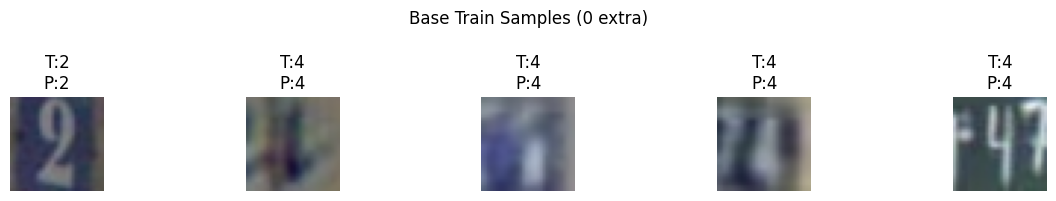

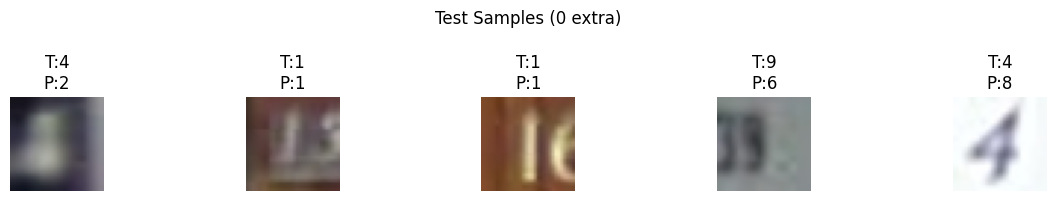

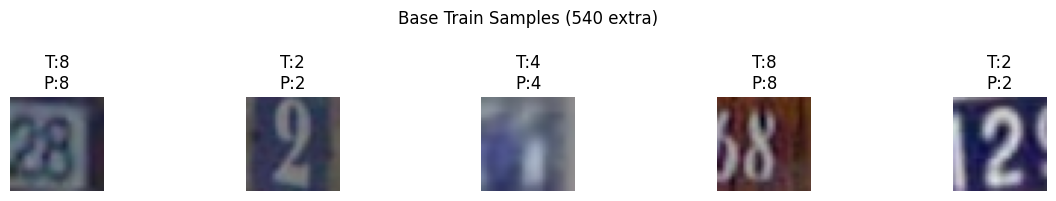

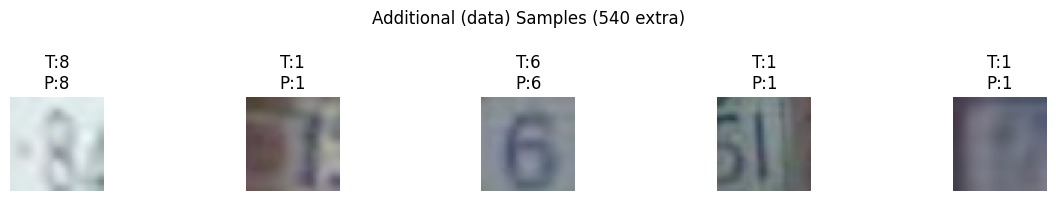

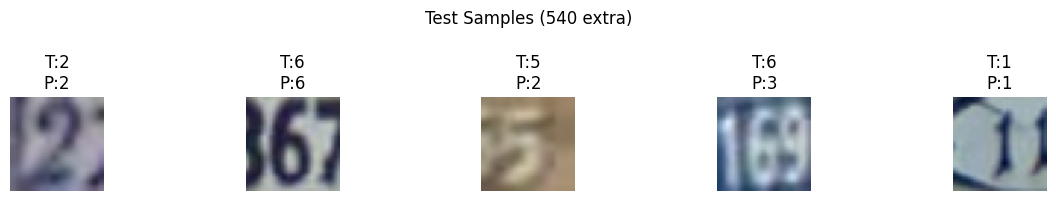

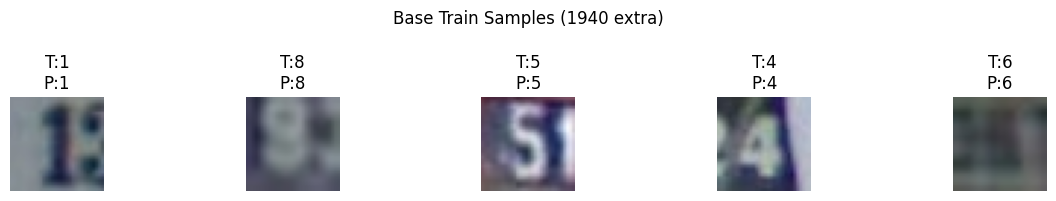

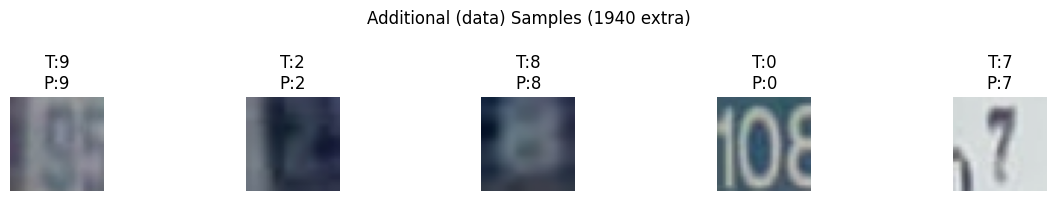

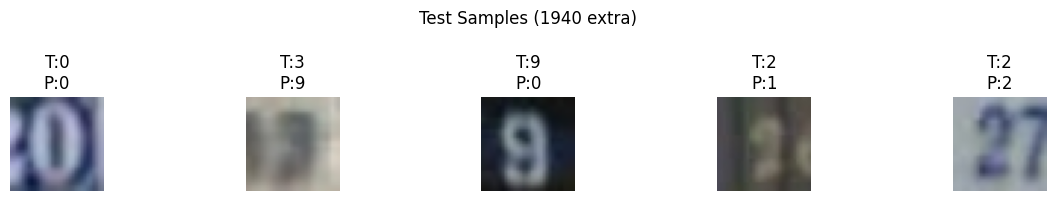

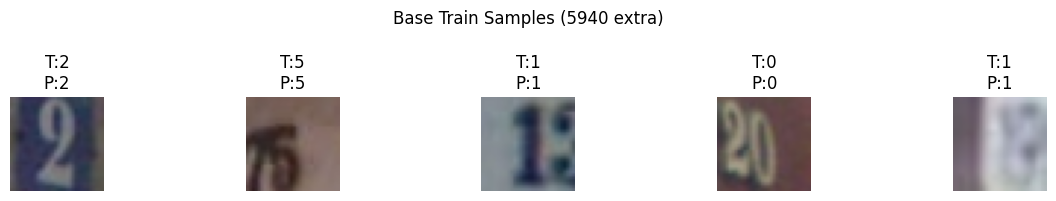

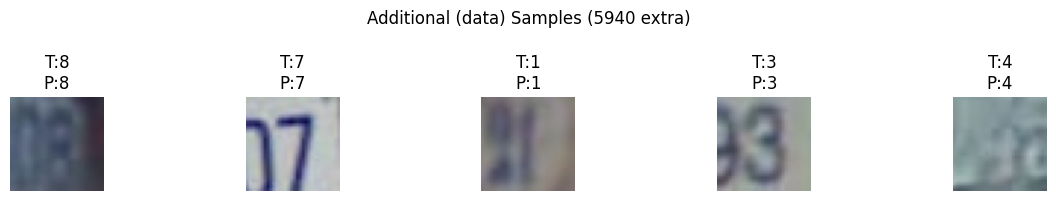

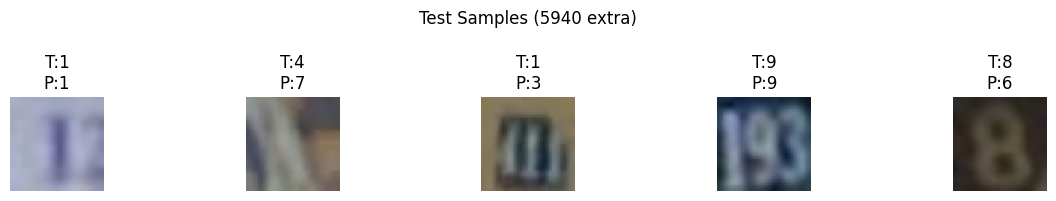

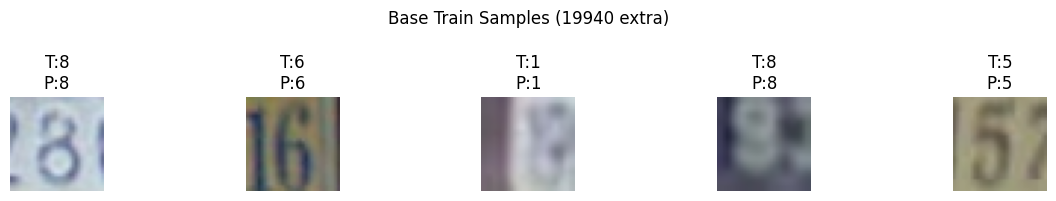

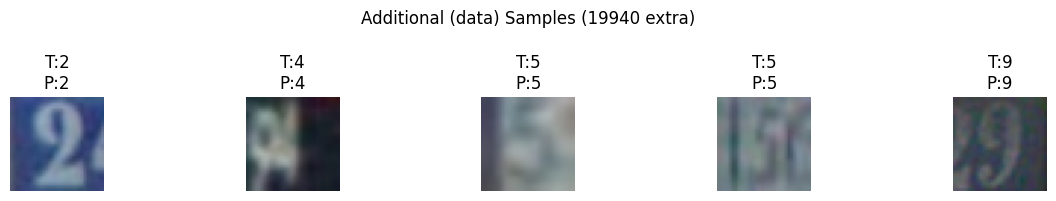

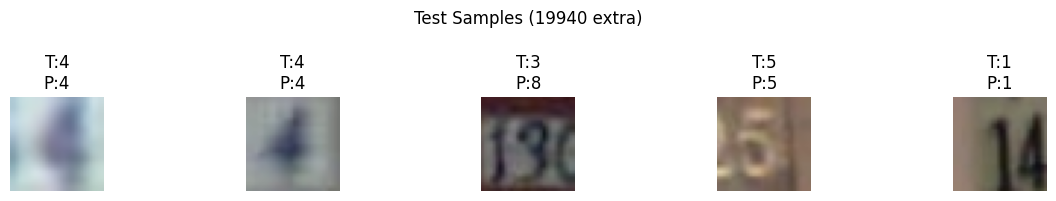

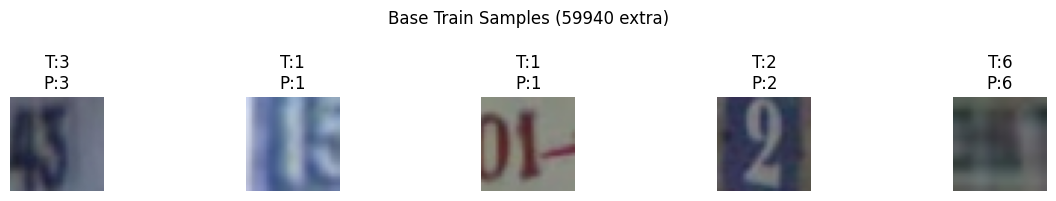

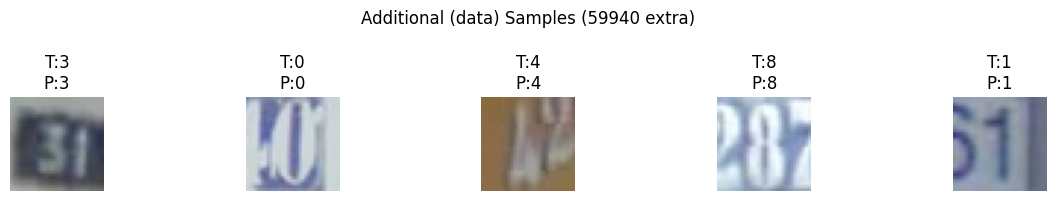

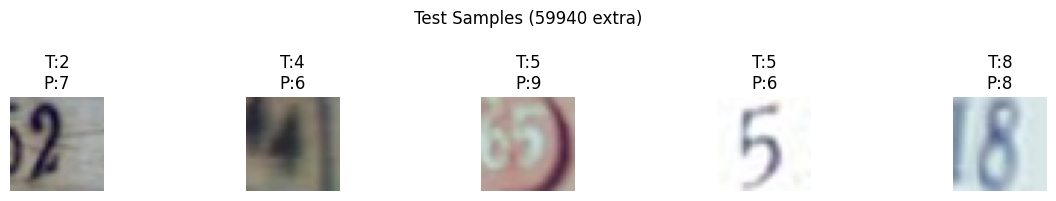

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
